# Notebook 4.1 - MobileNet v1

### 1. Setup constants

In [1]:
from constants import *

### 2. Imports and notebook setup

In [2]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
# Default imports
import os
import seaborn as sn
import re
import glob
import random
import shutil
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pylab as pl
import cv2

# Tensorflow
import tensorflow
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight

### 3. Load Data

#### 3.1 Load all train images to memory

In [4]:
X_train = []
y_train = []

for cls in BINARY_CLASSES:
    counter = 0
    for img in glob.glob(os.path.join(TRAIN_PATH, cls, '*.' + IMG_FORMAT)):
        counter += 1
        X_train.append(tensorflow.keras.applications.mobilenet.preprocess_input(plt.imread(img)))
    y_train = y_train + [(1 if cls == 'mel' else 0)] * counter

X_train = np.array(X_train)

#### 3.2 Load all validation images to memory

In [5]:
X_val = []
y_val = []

for cls in BINARY_CLASSES:
    counter = 0
    for img in glob.glob(os.path.join(VAL_PATH, cls, '*.' + IMG_FORMAT)):
        counter += 1
        X_val.append(tensorflow.keras.applications.mobilenet.preprocess_input(plt.imread(img)))
    y_val = y_val + [(1 if cls == 'mel' else 0)] * counter

X_val = np.array(X_val)

### 4. Create model

#### 4.1 Set version to avoid overwriting previous files

In [6]:
# Set version to avoid overwirting previous files
base_name = 'mobile_net_v'
version = 0
while any([bool(re.match(base_name + str(version), x)) for x in os.listdir('.')]):
    version += 1
print('version', version)

version 0


#### 4.2 Model Constants

In [7]:
# Constants
TRAIN_BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_EPOCHS = 50

num_train_samples = len(glob.glob(os.path.join(TRAIN_PATH, '*', '*.' + IMG_FORMAT)))
train_steps = np.ceil(num_train_samples / TRAIN_BATCH_SIZE)

#### 4.3 Transfer Learning MobileNet

In [8]:
# Load MobileNet
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [10]:
# mobile.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [9]:
# Set architecture
x = mobile.layers[-6].output

x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='tanh')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [10]:
# model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [12]:
# Freeze layers
for layer in model.layers:
    layer.trainable = False
    if layer.name == 'conv_pw_11_relu':
        break

In [13]:
# json_string = model.to_json()
# model.save('model_mobile_net.h5')

#### 4.5 Callbacks and metrics

In [14]:
model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.2, nesterov=True), 
              loss='binary_crossentropy', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

In [15]:
checkpoint = ModelCheckpoint(base_name + str(version) + '_auc_{val_auc:.3f}.h5', 
                             monitor='val_auc', mode='max', verbose=1,
                             save_best_only=True, save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.8, patience=6,
                                   verbose=1, mode='max', min_lr=0.001, cooldown=2)
                              
callbacks_list = [checkpoint, reduce_lr]

#### 4.6 Train Model

In [16]:
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

In [17]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
total = weights[0] + weights[1]
class_weights = {0: weights[0] / total, 1: weights[1] / total}
class_weights

{0: 0.2155241935483871, 1: 0.784475806451613}

In [18]:
# mel = len(os.listdir('../data_processed/train/mel/'))
# other = len(os.listdir('../data_processed/train/other/'))

# mel / (mel + other)

# 0.2155241935483871

0.2155241935483871

In [19]:
# X_train_reduced = np.concatenate((X_train[:100], X_train[-100:]))
# y_train_reduced = y_train[:100] + y_train[-100:]

# X_train_reduced.shape
# len(y_train_reduced)

# X_val.shape
# len(y_val)

(200, 224, 224, 3)

200

(2585, 224, 224, 3)

2585

In [20]:
history = model.fit_generator(datagen.flow(X_train, np.array(y_train), batch_size=TRAIN_BATCH_SIZE),
                              epochs=NUM_EPOCHS,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=(X_val, np.array(y_val)),
                              class_weight=class_weights)

Epoch 1/50
6/7 [========================>.....] - ETA: 2s - loss: 0.4115 - accuracy: 0.6012 - auc: 0.5960
Epoch 00001: val_auc improved from -inf to 0.57475, saving model to mobile_net_v0_auc_0.575.h5
7/7 [==============================] - 23s 3s/step - loss: 0.4261 - accuracy: 0.5800 - auc: 0.5640 - val_loss: 0.7233 - val_accuracy: 0.5050 - val_auc: 0.5748
Epoch 2/50
2/7 [=======>......................] - ETA: 12s - loss: 0.3580 - accuracy: 0.6562 - auc: 0.6344

KeyboardInterrupt: 

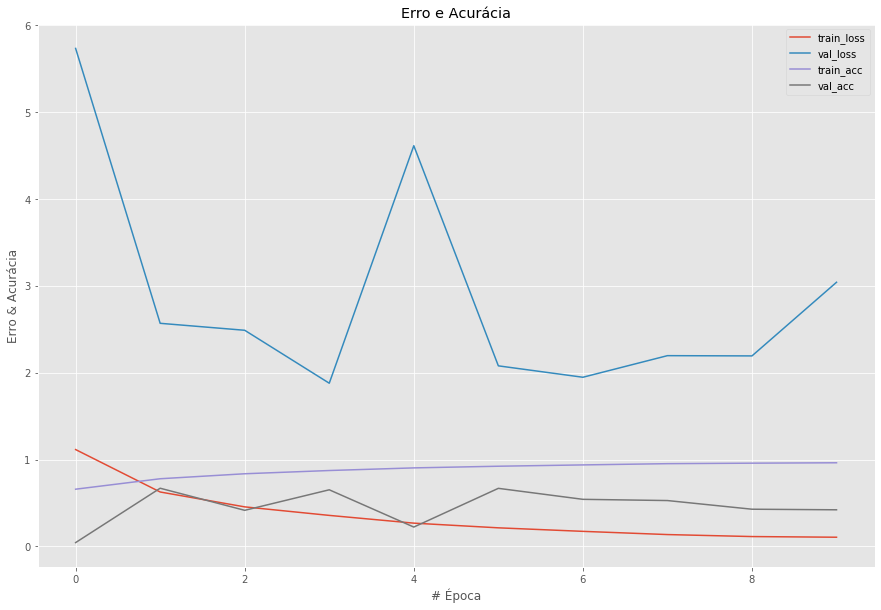

In [19]:
plt.style.use("ggplot")
_ = plt.figure(figsize=(15, 10))
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["acc"], label="train_acc")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_acc"], label="val_acc")
_ = plt.title("Erro e Acurácia")
_ = plt.xlabel("# Época")
_ = plt.ylabel("Erro & Acurácia")
_ = plt.legend(loc="upper right")

plt.savefig(base_name + str(version) + '_learning' + '.png')

### 3.7 Confusion matrix

In [75]:
probas = model.predict(X_val)

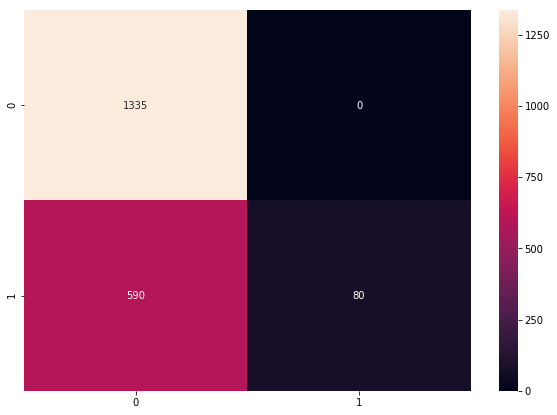

In [83]:
cm = confusion_matrix(y_true=y_val, y_pred=np.array(probas > 0.5, dtype=np.int32).flatten())

df_cm = pd.DataFrame(cm)
_ = plt.figure(figsize = (10, 7))
_ = sn.heatmap(df_cm, annot=True, fmt='d')

plt.savefig(base_name + str(version) + '_confusion_matrix.png')